In [1]:
import numpy as np
import pickle as pcl

from methods.training import load_data
from predict import predict

from tensorflow.keras.models import load_model

/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3

In [2]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')

from matplotlib import rc
rc('text', usetex=True)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({"text.usetex": False})

In [17]:
#     "mathtext.fontset": "dejavusans",
#     "font.family": 'sans-serif'

# plt.title("ABC123 vs $\mathrm{ABC123}^{123}$", size=25)

In [7]:
si = predict(fname='data/full_histories_illustris.h5')
si.training_mask()
si.filename

'data/full_histories_illustris.h5'

In [8]:
bins = si.load_arr('bins','bins/log_8')
binLimits = np.log10(si.load_arr('binLimits','bins/log_8') * 1e9)
binWidths = si.load_arr('binWidths','bins/log_8')

In [9]:
mstar = si.load_arr('Stellar Mass','Subhalos')[~si.train]
mgas = si.load_arr('Star Forming Gas Mass','Subhalos')[~si.train]
metal = si.load_arr('Gas Metallicity','Subhalos')[~si.train]
smetal = si.load_arr('Stellar Metallicity 30kpc','Subhalos')[~si.train]
sfr = si.load_arr('SFR 100Myr','Subhalos')[~si.train]

In [36]:
predictors = si.load_arr('log_8','SFH')
illustris_dust_noise, wl = si.load_spectra('Noisified Dust')
si.generate_standardisation(key='Dust Noise SN50', spec=illustris_dust_noise)
features = si.prepare_features(illustris_dust_noise, key='Dust Noise SN50', CNN=True)

cnn_model = load_model('data/cnn_trained_illustris_dust_noise50_x4.h5', 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction = cnn_model.predict(features[~si.train])
SMAPE = [si._SMAPE(predictors[~si.train][i], p) * 100 for i,p in enumerate(prediction)]

## Example histories

In [37]:
def total_error(sfh, experiment_err, model_err, key='intrinsic', fracs=False):
    """
    quadrature sum of model + spectra error
    """
    
    sigma = [None] * len(sfh)
    for i in np.arange(len(sfh)):
        m2,m1,c = experiment_err[key][i]
        sigma[i] = m2*np.log10(sfh[i])**2 + m1*np.log10(sfh[i]) + c
    
    sigma = np.array(sigma)
    # print(sigma)
    # print(sfh * model_err[key])
    
    tot_error = np.sqrt(sigma**2 + (sfh * model_err[key])**2)
    
    if fracs:
        return tot_error, sigma, sfh * model_err[key]
    else:
        return tot_error

    
sigma_1_model = pcl.load(open('data/sigma_1_model_illustris.p','rb'))
experiment_err_fits = pcl.load(open('data/experiment_err_fits_illustris.p','rb'))

499 811 816 1166 735 257


/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


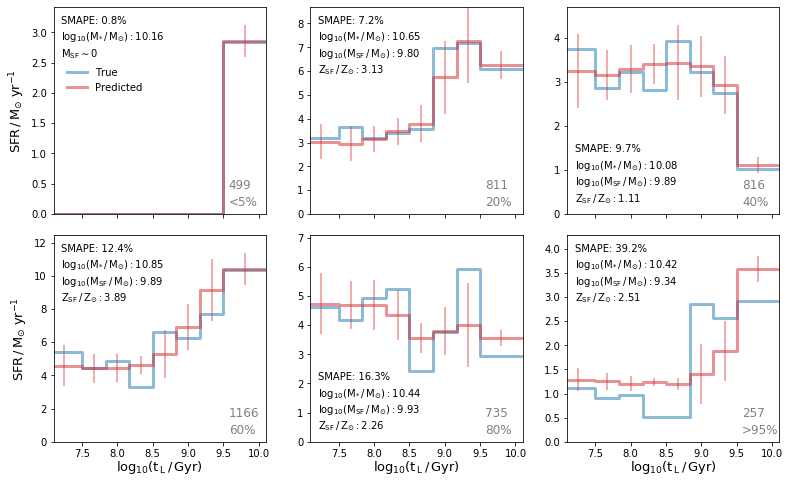

In [39]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(13,8))#, dpi=100)

plt.subplots_adjust(hspace=0.1, wspace=0.21)

err = SMAPE
v = np.argsort(err)[0]
j = np.argsort(err)[int(0.195 * (len(err) - 1))]
k = np.argsort(err)[int(0.395 * (len(err) - 1))]
l = np.argsort(err)[int(0.61 * (len(err) - 1))]
u = np.argsort(err)[int(0.805 * (len(err) - 1))]
m = np.argsort(err)[len(err)-6]
# v,j,k,l,u,m = [473,1080,734,1056,448,367]
print(v,j,k,l,u,m)

percentile_strings = ['<5%','20%','40%','60%','80%','>95%']

for ix, (idx, ax) in enumerate(zip([v,j,k,l,u,m], 
                               [ax1,ax2,ax3,ax4,ax5,ax6])):
    
    pred = np.hstack([predictors[~si.train][idx], predictors[~si.train][idx][-1]])
    pmax = np.max(pred)
    ax.step(binLimits, pred, where='post', alpha=0.5, label='True', color='C0', linewidth=3)
    
    colors=['C3','C2']
    ppred = prediction
    i = 0
    key='dust'
    
    p = np.hstack([ppred[idx], ppred[idx][-1]])        
    ax.step(binLimits, p, where='post', alpha=0.5, 
            label='Predicted', color=colors[i], linewidth=3) # key.title()

    # quadrature sum of model + spectra error
    tot_err = total_error(pred[:-1], experiment_err_fits, sigma_1_model, key=key)

    temp_bins = np.hstack([7.25, bins[1:]])+i/16
    ax.errorbar(temp_bins, p[:-1], yerr=tot_err, alpha=0.5, color=colors[i], fmt='none')

    pmax = np.max([pmax, np.max(p)])
    
    ax.set_xlim(7.1, 10.1)
    ax.set_ylim(0, pmax*1.2)
    
    ax.text(0.825, 0.04, percentile_strings[ix], transform=ax.transAxes, color='grey', size=12)
    ax.text(0.825, 0.12, idx, transform=ax.transAxes, color='grey', size=12)
    
    if ix in [0,1,3,5]:
        y_pos = 0.92
    else:
        y_pos = 0.3
        
        
    ax.text(0.035, y_pos, 
            'SMAPE: %.1f%%'%err[idx], 
            transform=ax.transAxes)
    
    ax.text(0.035, y_pos - 0.08, 
            r'$\mathrm{log_{10}(M_{*} \,/\, M_{\odot})}: %.2f$'%np.log10(mstar[idx]), 
            transform=ax.transAxes)
    
    if mgas[idx] != 0.:
        ax.text(0.035, y_pos - 0.16, 
            r'$\mathrm{log_{10}(M_{SF} \,/\, M_{\odot})}: %.2f$'%np.log10(mgas[idx]), 
            transform=ax.transAxes)
        ax.text(0.035, y_pos - 0.24, 
            r'$\mathrm{Z_{SF} \,/\, Z_{\odot}}: %.2f$'%(float(metal[idx])/0.0134), 
            transform=ax.transAxes)
    else:
        ax.text(0.035, y_pos - 0.16, r'$\mathrm{M_{SF} \sim 0}$', transform=ax.transAxes)
        

    if idx == v:
        ax.legend(loc='best', frameon=False, bbox_to_anchor=(0.46,0.75))
        

for ax in [ax4,ax5,ax6]:        
    ax.set_xlabel('$\mathrm{log_{10}(t_{\, L} \,/\, Gyr)}$', size=13, labelpad=0)

for ax in [ax1,ax4]:
    ax.set_ylabel('$\mathrm{SFR \,/\, M_{\odot} \; yr^{-1}}$', size=13)
    
for ax in [ax1,ax2,ax3]:
    ax.set_xticklabels([])

    
# fig.savefig('plots/panel_plot_illustris.png', dpi=200, bbox_inches='tight')

## Physical parameter correlations

Only available for original 1200 histories

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats import pearsonr

def colorbar(mappable, new_ax):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(new_ax)
    cax = divider.append_axes("right", size="50%")#, pad=0.05)
    return fig.colorbar(mappable, cax=cax), cax


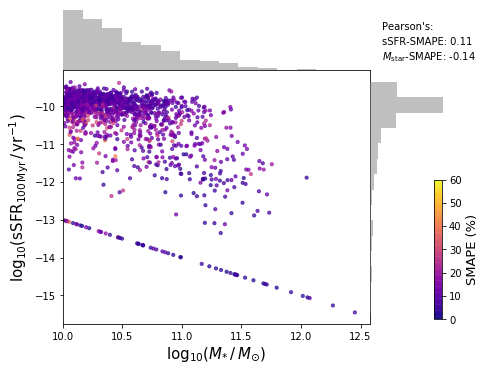

In [64]:
sfr_plot = sfr.copy()
sfr_plot[sfr_plot == 0.] = 1e-3
sSFR = sfr_plot / mstar

fig = plt.figure(figsize=(6, 5))
gs = gridspec.GridSpec(5, 5)

ax1 = plt.subplot(gs[0, 0:4])
ax2 = plt.subplot(gs[1:5, 0:4])
ax3 = plt.subplot(gs[0, 4])
ax4 = plt.subplot(gs[1:5, 4])

gs.tight_layout(fig)
gs.update(hspace=0, wspace=0)

ax1.hist(np.log10(mstar), alpha=0.5, bins=15, color='grey')
ax4.hist(np.log10(sSFR), orientation='horizontal', bins=15, alpha=0.5, color='grey')

ax1.axis('off')
ax4.axis('off')
ax3.axis('off')

scatter = ax2.scatter(np.log10(mstar), np.log10(sSFR), c=SMAPE, cmap='plasma', 
                      alpha=0.7, s=10., vmax=60, vmin=0);

cbaxes = inset_axes(ax4, width="10%", height="55%", loc=4) 
cb = plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
cb.set_label('SMAPE (%)', size=13)  # if latex, escape %, \%


ax2.set_xlabel('$\mathrm{log_{10}}(M_{*} \,/\, M_{\odot})$', size=15);
ax2.set_ylabel('$\mathrm{log_{10}(sSFR_{100 \, Myr} \,/\, \mathrm{yr^{-1}})}$', size=15);

ax2.text(1.04, 1.16, 'Pearson\'s:', transform=ax2.transAxes)

ax2.text(1.04, 1.10, 'sSFR-SMAPE: %.2f'%pearsonr(np.log10(sSFR), 
        np.array(SMAPE))[0], transform=ax2.transAxes)

ax2.text(1.04, 1.04, r'$M_{\mathrm{star}}$-SMAPE: %.2f'%pearsonr(mstar, SMAPE)[0], 
         transform=ax2.transAxes)

for ax in [ax1, ax2]:
    ax.set_xlim(10,)


# fig.savefig('plots/smape_mstar_sfr_illustris.png', dpi=200, bbox_inches='tight')

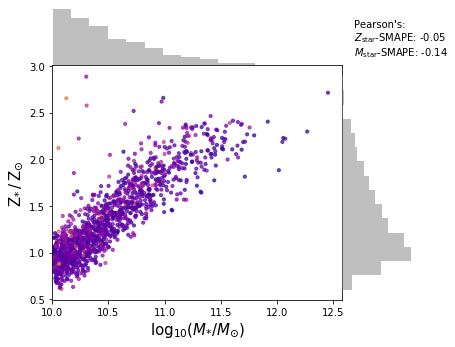

In [67]:
metals = smetal / 0.0134

fig = plt.figure(figsize=(6.5, 5.4))
gs = gridspec.GridSpec(5, 5)

ax1 = plt.subplot(gs[0, 0:4])
ax2 = plt.subplot(gs[1:5, 0:4])
ax3 = plt.subplot(gs[0, 4])
ax4 = plt.subplot(gs[1:5, 4])

gs.update(hspace=0, wspace=0)

ax1.hist(np.log10(mstar), alpha=0.5, bins=15, color='grey')
ax4.hist(metals, orientation='horizontal', bins=15, alpha=0.5, color='grey')

ax1.axis('off')
ax4.axis('off')

scatter = ax2.scatter(np.log10(mstar), metals, c=SMAPE, cmap='plasma', 
                      alpha=0.7, s=10, vmax=60, vmin=0);

# cbaxes = inset_axes(ax4, width="10%", height="55%", loc=4) 
# cb = plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# cb.set_label('SMAPE (%)', size=13)  # if latex, escape %, \%

ax3.axis('off')

ax2.text(1.04, 1.16, 'Pearson\'s:', transform=ax2.transAxes)

ax2.text(1.04, 1.04, '$Z_{\mathrm{star}}$-SMAPE: %.2f\n$M_{\mathrm{star}}$-SMAPE: %.2f'%\
         (pearsonr(metals, SMAPE)[0],pearsonr(mstar, SMAPE)[0]), 
         transform=ax2.transAxes)

ax2.set_xlabel('$\mathrm{log_{10}}(M_{*} / M_{\odot})$', size=15);
ax2.set_ylabel('$\mathrm{Z_{*} \,/\,Z_{\odot}}$', size=15);

for ax in [ax1, ax2]:
    ax.set_xlim(10,)


# fig.savefig('plots/smape_mstar_metals_illustris.png', bbox_inches='tight', dpi=200)